In [17]:
import numpy as np
from numpy import sin, cos, pi, square
import matplotlib.pyplot as plt


In [65]:
def rk4(f,y,t,dt, *args, **kwargs):
    k1 = f(t,y, *args, **kwargs)
    k2 = f(t+dt/2, y + dt*k1/2, *args, **kwargs)
    k3 = f(t+dt/2, y + dt*k2/2, *args, **kwargs)
    k4 = f(t+dt, y+dt*k3, *args, **kwargs)
    ret = y + dt*(k1 + 2*k2 + 2*k3 + k4)/6
    
    return ret

def euler(f,y,t,dt, *args, **kwargs):
    ret = y+f(t,y, *args, **kwargs)*dt
    return ret
def hopf(w,p,l, sigma=1):
    def f(t,x,s):
        
        u = x[0,:]
        v = x[1,:]
        dx = np.zeros(x.shape)
        sqr = (square(u)+square(v))/square(p)
        dx[1,:] = -w*u - l*(sqr-sigma)*v + s[1,:]
        dx[0,:] = w*v - l*(sqr-sigma)*u + s[0,:]
        return dx
    return f
class OscillatorNode(object):
    def __init__(self, ix, iw, ip, il, si, isigma=1, method='euler'):
        self.estimator = euler if method=='euler' else rk4
        self.x = ix.copy()
        self.last_t = None
        self.set_hopf(iw, ip, il, isigma)
        self.s = si
    def set_hopf(self,w,p,l,sigma):
        self.f =  hopf(w,p,l,sigma)
        
    def step(self,t):
        
        if self.last_t is None:
            dt = 0.001
        else:
            dt = t - self.last_t
        self.last_t = t
        new_x = self.estimator(self.f, self.x, t, dt, s=self.s)
        self.x = new_x
        self._update_s()
        return self.x
    
    def _update_s(self):
        pass

Text(0,0.5,'v')

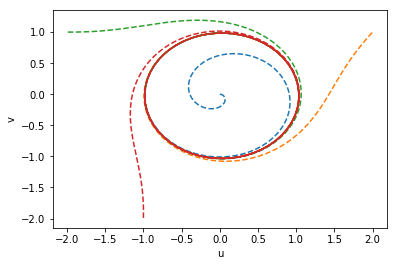

In [19]:
def generate_trajectory(total_t, dt, **params):
    n = OscillatorNode(**params)
    hist = []
    for t in np.linspace(0,total_t, total_t/dt):
    
        x = n.step(t).copy()
        hist.append(x)
    
    hist = np.array(hist)
    return hist

iw = 2
ip = 1
il = 1
si = np.array([[.1],[0]])
total_t = 10
dt = 0.01

ix = np.zeros((2,1))
traj_1 = generate_trajectory(total_t=total_t, dt=dt, ix=ix, iw=iw, ip=ip, il=1, si=si)
ix = np.array([[2],[1]])
traj_2 = generate_trajectory(total_t=total_t, dt=dt, ix=ix, iw=iw, ip=ip, il=1, si=si)
ix = np.array([[-2],[1]])
traj_3 = generate_trajectory(total_t=total_t, dt=dt, ix=ix, iw=iw, ip=ip, il=1, si=si)
ix = np.array([[-1],[-2]])
traj_4 = generate_trajectory(total_t=total_t, dt=dt, ix=ix, iw=iw, ip=ip, il=1, si=si)

plt.plot(traj_1[:,0,0], traj_1[:,1,0], ls='--')
plt.plot(traj_2[:,0,0], traj_2[:,1,0],  ls='--')
plt.plot(traj_3[:,0,0], traj_3[:,1,0], ls='--')
plt.plot(traj_4[:,0,0], traj_4[:,1,0], ls='--')
plt.xlabel('u')
plt.ylabel('v')

In [20]:
def rot2d(w):
    return np.array([[cos(w), -sin(w)],[sin(w), cos(w)]])
class CoupledOscillator(OscillatorNode):
    '''
    A coupled oscillator of the form 4.c from Zang et al. (2017). 
    The assumption here is that the first n/2 oscillators are the left side of the coupled pair
    and last n/2 oscillators are the right side
    '''
    def __init__(self, dl=pi/5 ,k=1,a=0.4, b=1,c=0.9, d=1,*args, **kwargs):
        self.set_dl(dl)
        self.k = k
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        super(CoupledOscillator, self).__init__(*args, **kwargs)
    def set_dl(self,dl):
        self.dl = dl
    def _update_s(self):
        n = self.s.shape[1]
        a = self.a
        b = self.b
        c = self.c
        d = self.d
        k = self.k
        x = self.x
        n2 = int(n/2)
        r = rot2d(self.dl)
        ir = rot2d(-self.dl)
        r90 = rot2d(pi)
        rn90 = rot2d(-pi/2)
        s = self.s
        for i in range(n2):
            
            s[:,i] = -d*(x[:,i] - np.matmul(r90,x[:, n2+i]))
            if i < n2-1:
                s[:,i] += -a*(x[:,i] - np.matmul(r,x[:, i+1]))
            if i > 0:
                s[:,i] += -b*(x[:,i] - np.matmul(r,x[:, i-1] )) 
            s[:,i] *= k
        for i in range(n2,n):
            
            s[:,i] = -c*(x[:,i] - np.matmul(rn90,x[:,i-n2])) 
            if i < n-1:
                s[:,i] += -a*(x[:,i] - np.matmul(ir,x[:, i+1]))
            if i > n2:
                s[:,i] += -b*(x[:,i] - np.matmul(ir,x[:, i-1]))
            s[:,i] *= k
        self.s = s




In [21]:
ix = np.zeros((2,20))
si = np.zeros((2,20))
si[0,:] += 0.1
iw = 1
ip = 1
il = 1

n = CoupledOscillator(ix=ix, iw=iw, ip=1, il=1, si=si,method='euler')
n.set_dl(pi/5)
hist = []
s_hist = []
total_t = 40
dt = 0.01
for t in np.linspace(0,total_t, total_t/dt):
    
    x = n.step(t).copy()
    hist.append(x)
    s_hist.append(n.s.copy())
hist = np.array(hist)
s_hist = np.array(s_hist)
   
    

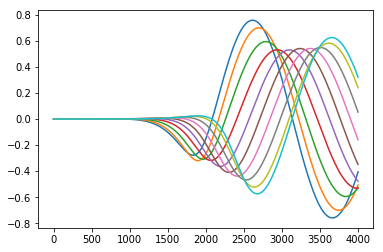

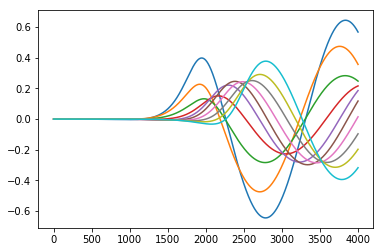

In [22]:
fig, ax = plt.subplots()
ax.plot(hist[:,0,:10])  
fig, ax = plt.subplots()
ax.plot(hist[:,0,10:])

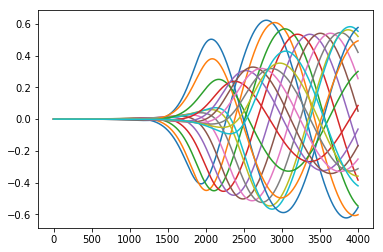

In [23]:
plt.plot(s_hist[:,1,:])    

In [58]:
import rospy
from std_msgs.msg import Float64

In [66]:
class CoupledOscillatorController(CoupledOscillator):
    def __init__(self, *args, **kwargs):
        super(CoupledOscillatorController, self).__init__(*args, **kwargs)
        n = self.x.shape[0]
        rospy.init_node("CoupledOscillatorController")
        self.pubs = []
        for i in range(n):
            
            pub = rospy.Publisher('/snakebot/joint_{}_position_controller/command'.format(i+1), Float64, queue_size=10)
            self.pubs.append(pub)

    def step(self, *args, **kwargs):
        t = rospy.get_time()
        super(CoupledOscillatorController, self).step(t,*args, **kwargs)
        for i, pub in enumerate(self.pubs):
            pub.publish(self.x[0,i])


In [67]:
ix = np.zeros((2,20))
si = np.zeros((2,20))
si[0,:] += 0.1
iw = 3
ip = 1
il = 1

node = CoupledOscillatorController(ix=ix, iw=iw, ip=1, il=1, si=si,method='euler')
hz = 100
rate = rospy.Rate(hz)


while not rospy.is_shutdown():
    node.step()
    rate.sleep()
